In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import torch

In [2]:
# Arguments
args = Namespace(
    seed=1024,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=500,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)
pprint.pprint(vars(args),indent = 4)

{   'dimensions': 2,
    'learning_rate': 1.0,
    'num_classes': 3,
    'num_epochs': 200,
    'num_hidden_units': 500,
    'num_samples_per_class': 500,
    'regularization': 0.001,
    'seed': 1024,
    'test_size': 0.25,
    'train_size': 0.75}


In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.25 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    print(np.shape(X_original))
    X = np.hstack([X_original])
    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

(1500, 2)
X: (1500, 2)
y: (1500,)


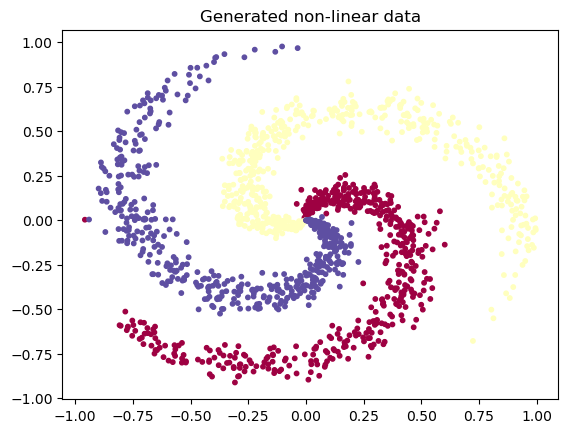

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(type(X),type(y))
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print(X.type(),y.type())
print(X)
print(y)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.FloatTensor torch.LongTensor
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 1.4252e-04,  1.9989e-03],
        [ 1.4851e-03,  3.7227e-03],
        ...,
        [-3.8856e-01,  9.1707e-01],
        [-3.5308e-01,  9.3345e-01],
        [-5.6905e-01,  8.2230e-01]])
tensor([0, 0, 0,  ..., 2, 2, 2])


In [7]:
z = random.sample(range(0,len(X)),len(X))
s_index = torch.LongTensor(z)
print(z)
X = X[s_index]
y = y[s_index]
test_index_s = int(len(X) * args.train_size)
print(test_index_s)
X_train = X[:test_index_s]
y_train = y[:test_index_s]
X_test = X[test_index_s:]
y_test = y[test_index_s:]
print("This case contians %i train samples and %i test samples" % (len(X_train), len(y_test)))

[817, 298, 637, 1264, 818, 475, 858, 871, 743, 1310, 510, 333, 1303, 1384, 1221, 254, 26, 84, 83, 425, 230, 1225, 255, 1020, 1471, 1468, 925, 607, 790, 667, 374, 1136, 101, 146, 383, 936, 470, 521, 1361, 439, 697, 1375, 1030, 467, 1458, 498, 850, 1028, 1299, 1170, 1288, 441, 717, 491, 161, 699, 131, 1400, 949, 22, 594, 458, 1457, 1124, 958, 976, 1482, 1365, 1418, 907, 460, 1368, 23, 893, 1444, 8, 1215, 459, 438, 312, 1214, 1473, 165, 294, 518, 1296, 799, 481, 1263, 48, 1275, 713, 1429, 1267, 409, 582, 905, 1285, 1464, 302, 411, 1090, 377, 278, 404, 1200, 350, 124, 615, 862, 482, 415, 763, 679, 890, 527, 1032, 1278, 1284, 663, 1421, 216, 1079, 902, 322, 920, 722, 896, 433, 1289, 1010, 346, 794, 1101, 1166, 1352, 296, 310, 1242, 222, 774, 1461, 344, 158, 669, 585, 919, 1253, 984, 620, 616, 704, 462, 1295, 188, 89, 494, 1218, 953, 70, 205, 1494, 940, 1216, 398, 791, 99, 1217, 1015, 874, 512, 854, 45, 852, 98, 466, 1340, 993, 1325, 1417, 529, 977, 595, 857, 126, 1008, 807, 519, 137, 972, 7

In [8]:
# test for a liner model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
class LogisticClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LogisticClassifier,self).__init__()#get init func from nn.Module
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x_in,apply_Softmax = False):
        a_1 = self.fc1(x_in)
        a_2 = self.fc2(a_1)
        y_pred = self.fc3(a_2)

        if apply_Softmax :
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [10]:
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>


In [11]:
loss_f = nn.CrossEntropyLoss()#which contains the softmax, so in train step Softmax = False
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [12]:
def get_Accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    # how mant numbers about y_pred[element] == y_target[element]
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)#index of the max value of y_pred
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_f(y_pred,y_train)

    if t%10 == 0:
        print( " epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy
        )
             )
        print(" ----- ----- ----- ----- ----- ----- ----- ----- ")
        print("y_pred:", y_pred)
        print("predicitions:",predictions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 epoch: 00 | loss: 1.1340 | accuracy: 25.0%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[ 0.1437, -0.0889, -0.0919],
        [ 0.0993, -0.0254,  0.0768],
        [ 0.0962, -0.0091, -0.0591],
        ...,
        [ 0.1687, -0.1350, -0.0572],
        [ 0.1700, -0.1374, -0.0543],
        [ 0.0447,  0.0760, -0.0074]], grad_fn=<AddmmBackward0>)
predicitions: tensor([0, 0, 0,  ..., 0, 0, 1])
 epoch: 10 | loss: 40545.1875 | accuracy: 54.6%
 ----- ----- ----- ----- ----- ----- ----- ----- 
y_pred: tensor([[-467803.5938,  111126.3359, -148654.3750],
        [ 260820.5469, -140787.7500,  101978.9062],
        [-205121.0625,   -8856.2363,  -41932.3438],
        ...,
        [-423851.0000,  121560.4219, -147917.2500],
        [-417781.5625,  120961.2031, -146670.7812],
        [ 135775.6562, -155156.4688,   91287.6094]], grad_fn=<AddmmBackward0>)
predicitions: tensor([1, 0, 1,  ..., 1, 1, 0])
 epoch: 20 | loss: 12405.6602 | accuracy: 41.5%
 ----- ----- ----- ----- ----- -----

In [14]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)
print("pred_train:",pred_train)
print("----- ----- ----- ----- -----")
print("pred_test:",pred_test)


pred_train: tensor([1, 0, 2,  ..., 1, 1, 2])
----- ----- ----- ----- -----
pred_test: tensor([2, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1,
        2, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 1, 0, 0,
        2, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2,
        1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0,
        1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0,
        2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1,
        2, 0, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 2, 2,
        2, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1,
        2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 0,
        2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1,
        1, 0, 2, 0, 2, 1, 1, 0, 2,

In [15]:
# Train and test accuracies
train_acc = get_Accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 51.2%, test acc: 53.9%


In [16]:
def plot_multiclass_decision_boundary(model,X,y):
    x_min = X[:,0].min()-0.1
    x_max = X[:,0].max() + 0.1
    y_min = X[:,1].min() - 0.1
    y_max = X[:,1].max() + 0.1
    print("x_max:",x_max)
    print("x_min:",x_min)
    print("y_max:",y_max)
    print("y_min:",y_min)
    xx,yy = np.meshgrid( np.linspace( x_min,x_max,101 ),np.linspace( y_min,y_max,101 ) )
    print("----- ----- ----- ----- ----- -----")

    print("xx:",xx)

    print("----- ----- ----- ----- ----- -----")

    print("yy:",yy)

    X_test = torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()

    print("----- ----- ----- ----- ----- -----")

    print("x_test:",X_test)
    
    y_pred = model(X_test,apply_Softmax = True)
    _,y_pred = y_pred.max(dim = 1)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    

x_max: tensor(1.0965)
x_min: tensor(-1.0399)
y_max: tensor(1.0673)
y_min: tensor(-1.0114)
----- ----- ----- ----- ----- -----
xx: [[-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 ...
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]]
----- ----- ----- ----- ----- -----
yy: [[-1.01142991 -1.01142991 -1.01142991 ... -1.01142991 -1.01142991
  -1.01142991]
 [-0.99064283 -0.99064283 -0.99064283 ... -0.99064283 -0.99064283
  -0.99064283]
 [-0.96985576 -0.96985576 -0.96985576 ... -0.96985576 -0.96985576
  -0.96985576]
 ...
 [ 1.02570328  1.02570328  1.02570328 ...  1.02570328  1.02570328
   1.02570328]
 [ 1.0464

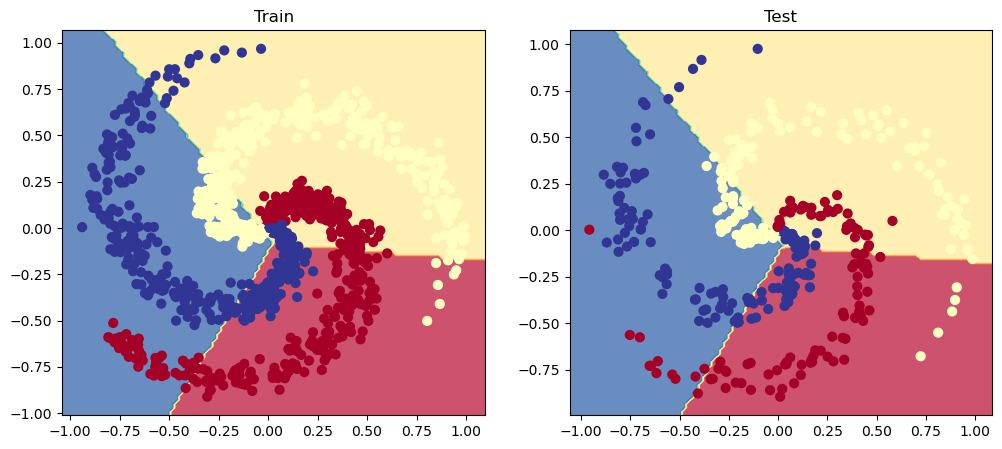

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


In [18]:
# apply noliner model by multilayer Perceptron
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
    def forward(self,x_in,apply_Softmax = False):
        #a1 = F.relu(self.fc1(x_in))
        #a2 = F.relu(self.fc2(a1))
        a2 = F.relu(self.fc1(x_in))
        y_pred = self.fc3(a2)

        if apply_Softmax:
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [19]:
model = MLP(
    input_dim=args.dimensions,
    hidden_dim=args.num_hidden_units,
    output_dim=args.num_classes
)
print(model.named_modules)
print(model.named_parameters)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>
<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
)>


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()
                      ,lr = args.learning_rate)

In [21]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim=1)
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)

    loss = loss_fn(y_pred,y_train)

    if t%10 == 0:
        print("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t,loss,accuracy
        ))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 00 | loss: 1.1430 | accuracy: 14.7%
epoch: 10 | loss: 2.7437 | accuracy: 71.3%
epoch: 20 | loss: 0.5326 | accuracy: 83.6%
epoch: 30 | loss: 0.2421 | accuracy: 91.6%
epoch: 40 | loss: 0.1428 | accuracy: 95.0%
epoch: 50 | loss: 0.0723 | accuracy: 97.4%
epoch: 60 | loss: 0.0424 | accuracy: 99.2%
epoch: 70 | loss: 0.0332 | accuracy: 99.4%
epoch: 80 | loss: 0.0283 | accuracy: 99.6%
epoch: 90 | loss: 0.0256 | accuracy: 99.5%
epoch: 100 | loss: 0.0236 | accuracy: 99.6%
epoch: 110 | loss: 0.0222 | accuracy: 99.6%
epoch: 120 | loss: 0.0209 | accuracy: 99.6%
epoch: 130 | loss: 0.0198 | accuracy: 99.6%
epoch: 140 | loss: 0.0189 | accuracy: 99.7%
epoch: 150 | loss: 0.0180 | accuracy: 99.7%
epoch: 160 | loss: 0.0172 | accuracy: 99.8%
epoch: 170 | loss: 0.0166 | accuracy: 99.8%
epoch: 180 | loss: 0.0159 | accuracy: 99.8%
epoch: 190 | loss: 0.0154 | accuracy: 99.8%


In [22]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)

In [23]:
train_acc = get_Accuracy(y_pred=pred_train,y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test,y_target=y_test)

In [24]:
print("train accuracy: {0:.1f}% | test accuracy: {1:.1f}%".format(train_acc,test_acc))

train accuracy: 99.8% | test accuracy: 98.9%


x_max: tensor(1.0965)
x_min: tensor(-1.0399)
y_max: tensor(1.0673)
y_min: tensor(-1.0114)
----- ----- ----- ----- ----- -----
xx: [[-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 ...
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]
 [-1.03987074 -1.0185069  -0.99714305 ...  1.05378582  1.07514967
   1.09651351]]
----- ----- ----- ----- ----- -----
yy: [[-1.01142991 -1.01142991 -1.01142991 ... -1.01142991 -1.01142991
  -1.01142991]
 [-0.99064283 -0.99064283 -0.99064283 ... -0.99064283 -0.99064283
  -0.99064283]
 [-0.96985576 -0.96985576 -0.96985576 ... -0.96985576 -0.96985576
  -0.96985576]
 ...
 [ 1.02570328  1.02570328  1.02570328 ...  1.02570328  1.02570328
   1.02570328]
 [ 1.0464

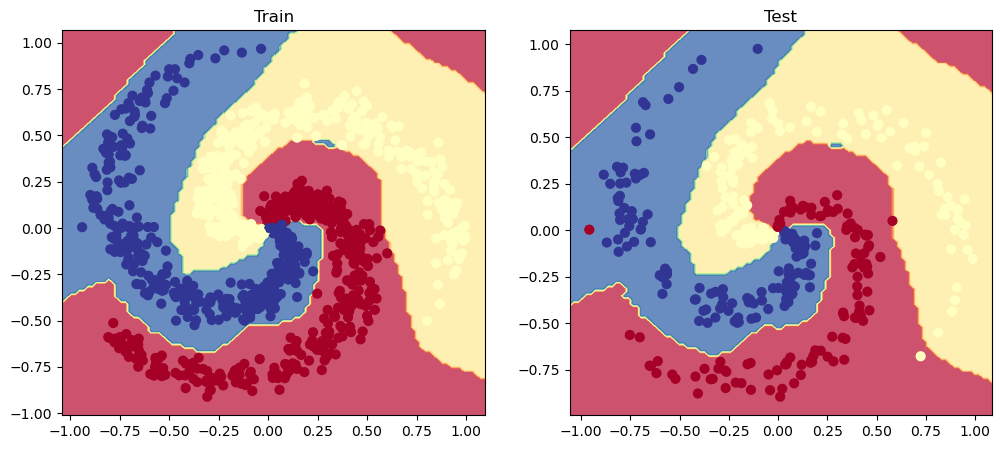

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model,X=X_train,y = y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model,X = X_test,y = y_test)
plt.show()